## Final Project - Intepretation and Discussion

In [1]:
import re
import string
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
#Clean emojis from text

def strip_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)

In [3]:
#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

In [4]:
#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

In [5]:
#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [6]:
# read data
df_train = pd.read_csv("Corona_NLP_train.csv", 
                       encoding='latin-1')
df_test = pd.read_csv("Corona_NLP_test.csv", 
                      encoding='latin-1')

df_train = df_train[['OriginalTweet', 'Sentiment']]
df_test = df_test[['OriginalTweet', 'Sentiment']]

In [7]:
# clean data
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(strip_emoji)
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(strip_all_entities)
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(clean_hashtags)
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(filter_chars)
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(remove_mult_spaces)

df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(strip_emoji)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(strip_all_entities)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(clean_hashtags)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(filter_chars)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(remove_mult_spaces)

In [8]:
# Preprocess the data
df_train['Sentiment'] = df_train['Sentiment'].replace(['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'], 
                                                      [0, 1, 2, 3, 4])
X = df_train['OriginalTweet'].values
y = df_train['Sentiment'].values

In [25]:
# Create a CountVectorizer representation of the data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)
X = X.astype(np.float64)

<class 'scipy.sparse._csr.csr_matrix'>


In [13]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(C = 1, max_iter=1000, penalty='l1', solver='saga', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)

0.6758187048996063


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


##BERT

In [9]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 18.3 MB/s eta 0:00:00


In [10]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.4 MB/s eta 0:00:00


In [12]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import transformers

In [13]:
# load the emotion dataset
data = pd.DataFrame({'text':df_train['OriginalTweet'],'emotion':df_train['Sentiment']})

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("./sentiment_transfer_learning_transformer/")

# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained('./sentiment_transfer_learning_transformer/')

In [17]:
# build a pipeline object to do predictions
pred = transformers.pipeline("text-classification", model=loaded_model, tokenizer=tokenizer, device=-1, top_k=None)


In [18]:
explainer = shap.Explainer(pred)

In [43]:
shap_values = explainer(data['text'][:3])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 2/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 4it [02:41, 80.58s/it]


In [44]:
shap.plots.text(shap_values)

In [46]:
shap.plots.text(shap_values[:, :, "LABEL_0"])

In [26]:
shap.plots.text(shap_values[:, :, "LABEL_1"])

In [27]:
shap.plots.text(shap_values[:, :, "LABEL_2"])

In [28]:
shap.plots.text(shap_values[:, :, "LABEL_3"])

In [29]:
shap.plots.text(shap_values[:, :, "LABEL_4"])

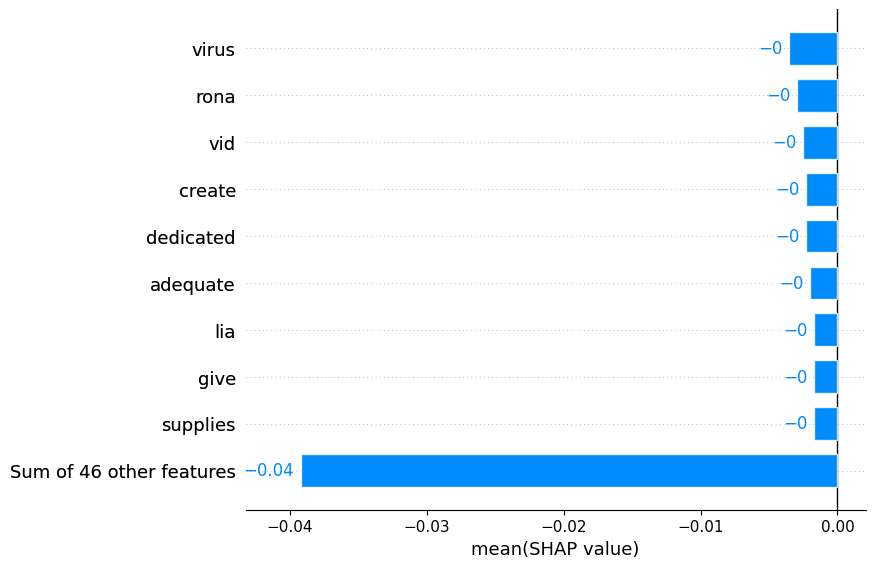

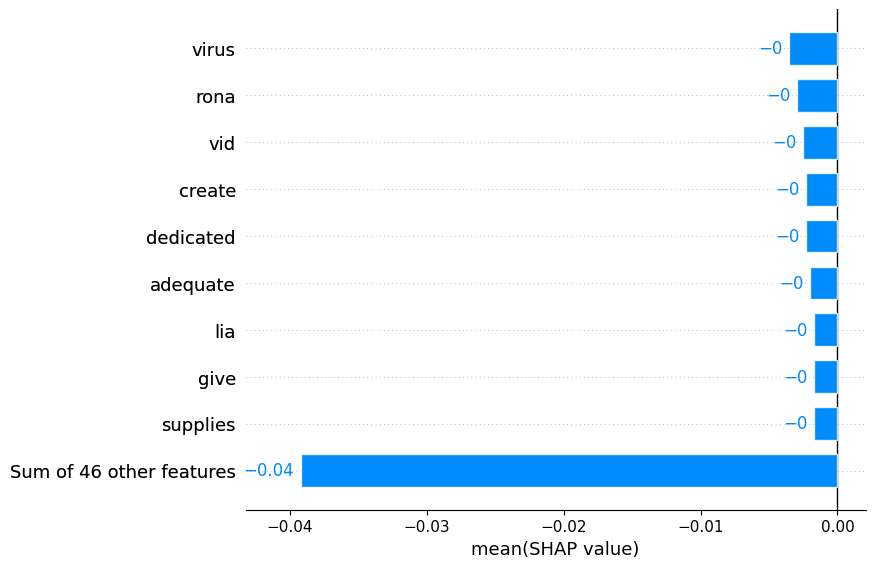

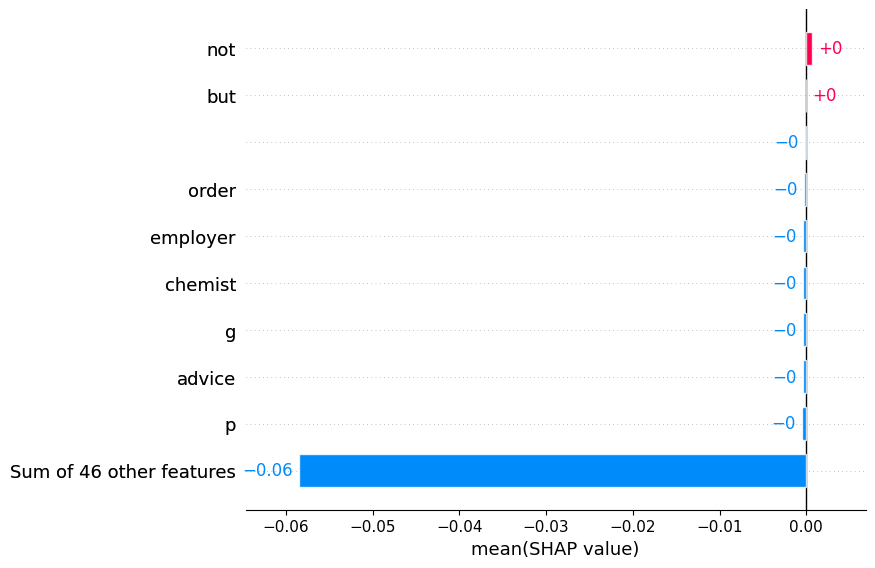

In [38]:
shap.plots.bar(shap_values[:,:,"LABEL_0"].mean(0))
shap.plots.bar(shap_values[:,:,"LABEL_0"].mean(0), order=shap.Explanation.argsort)
shap.plots.bar(shap_values[:,:,"LABEL_0"].mean(0), order=shap.Explanation.argsort.flip)

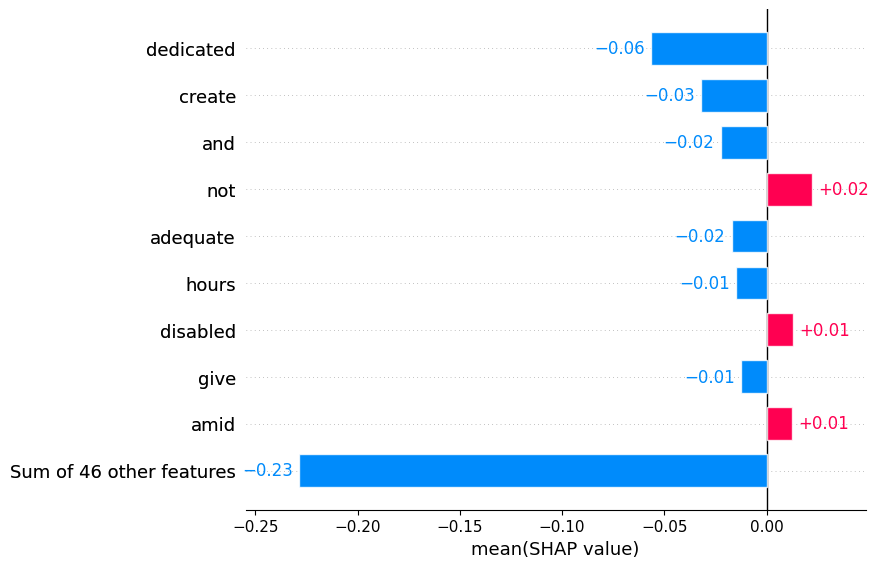

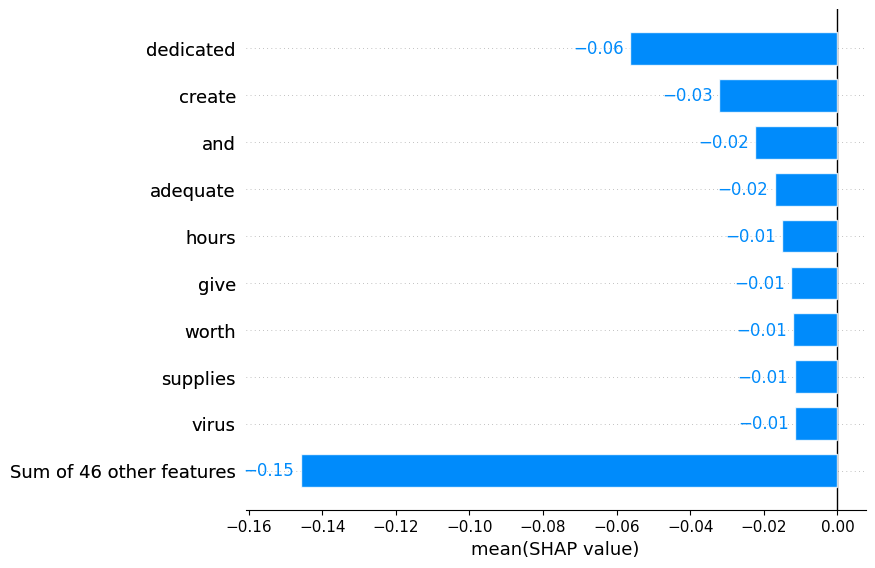

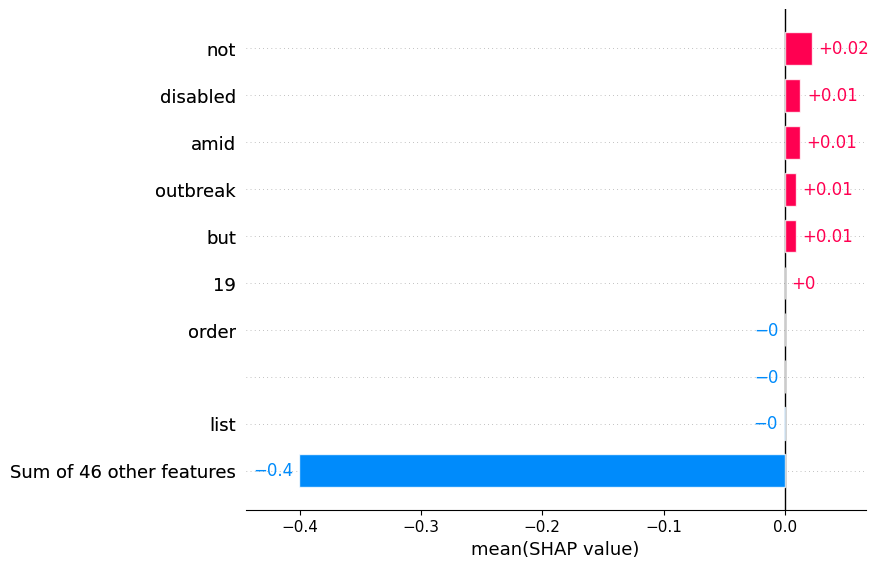

In [37]:
shap.plots.bar(shap_values[:,:,"LABEL_1"].mean(0))
shap.plots.bar(shap_values[:,:,"LABEL_1"].mean(0), order=shap.Explanation.argsort)
shap.plots.bar(shap_values[:,:,"LABEL_1"].mean(0), order=shap.Explanation.argsort.flip)

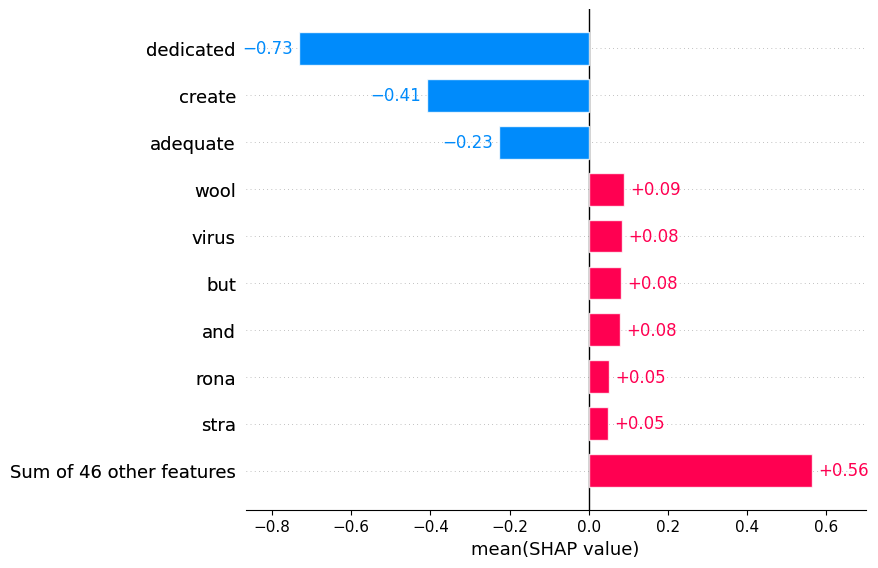

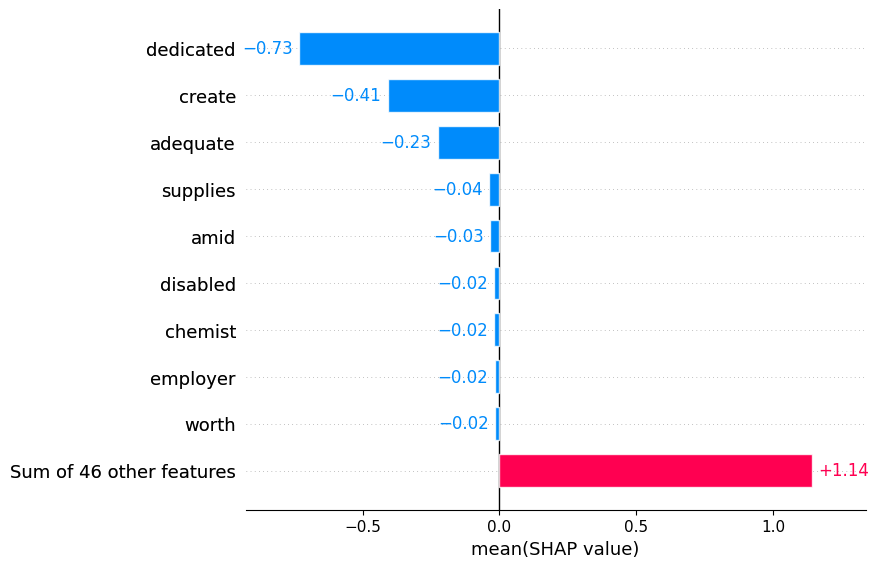

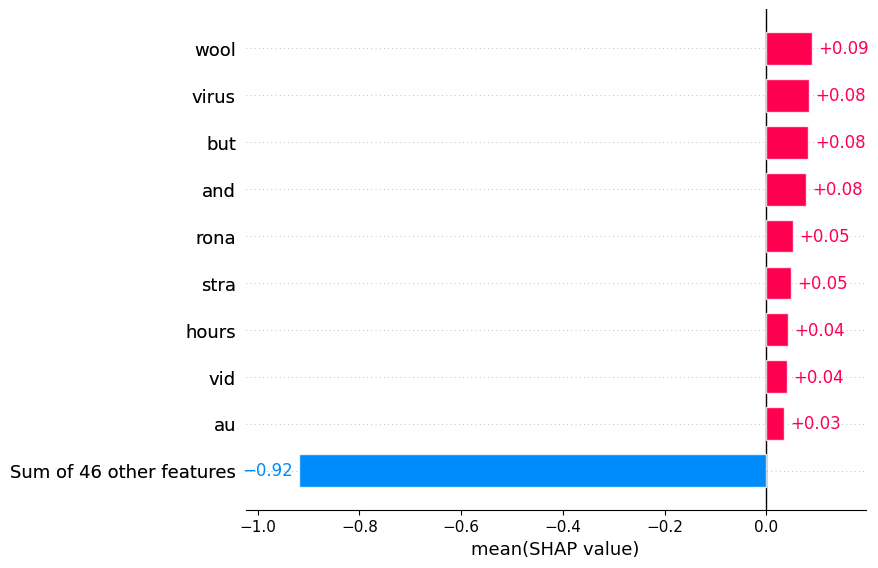

In [39]:
shap.plots.bar(shap_values[:,:,"LABEL_2"].mean(0))
shap.plots.bar(shap_values[:,:,"LABEL_2"].mean(0), order=shap.Explanation.argsort)
shap.plots.bar(shap_values[:,:,"LABEL_2"].mean(0), order=shap.Explanation.argsort.flip)

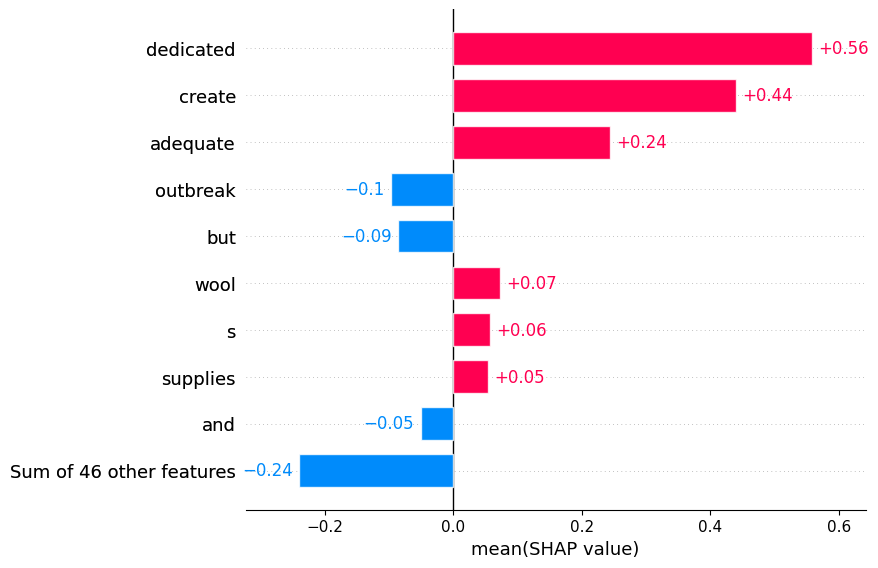

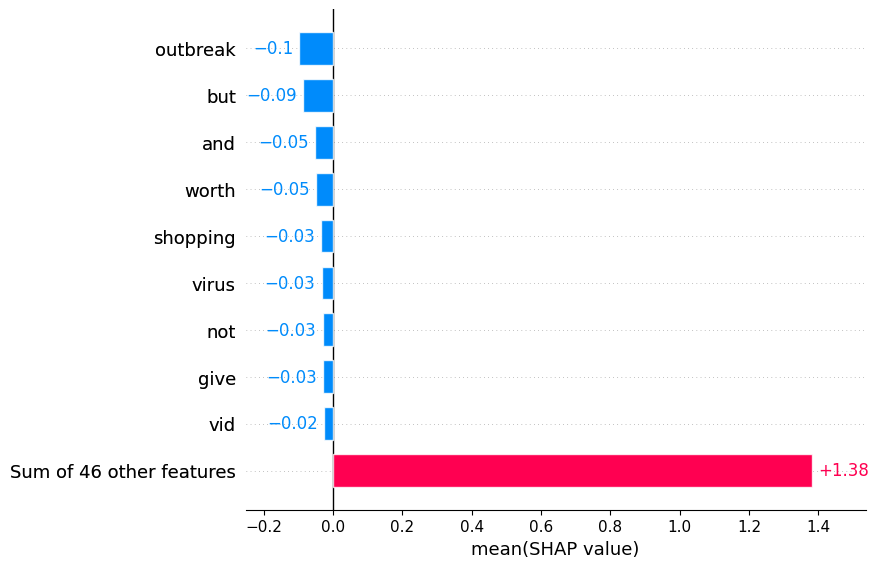

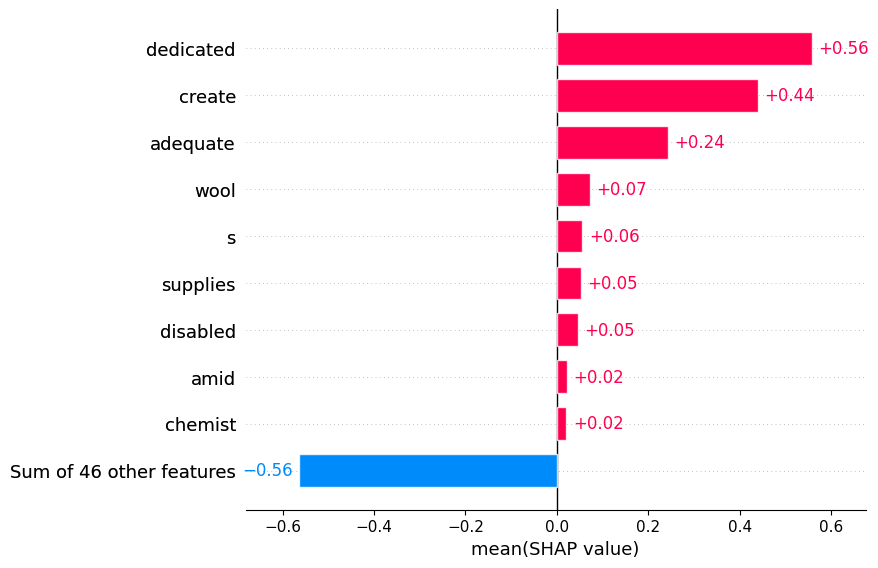

In [40]:
shap.plots.bar(shap_values[:,:,"LABEL_3"].mean(0))
shap.plots.bar(shap_values[:,:,"LABEL_3"].mean(0), order=shap.Explanation.argsort)
shap.plots.bar(shap_values[:,:,"LABEL_3"].mean(0), order=shap.Explanation.argsort.flip)

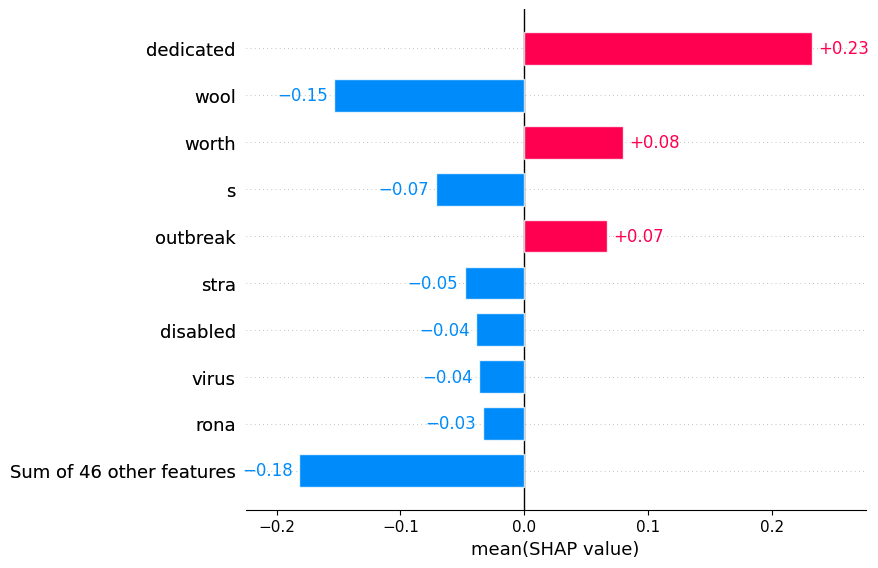

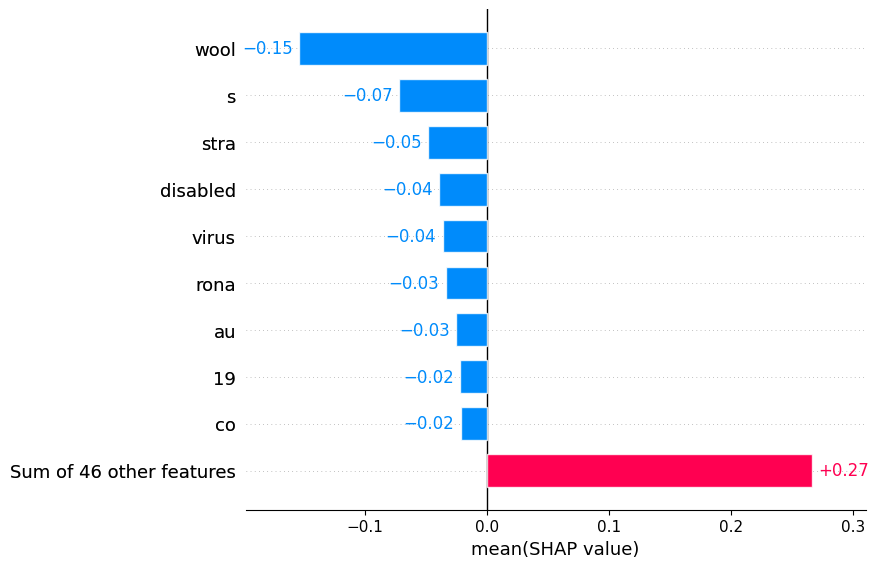

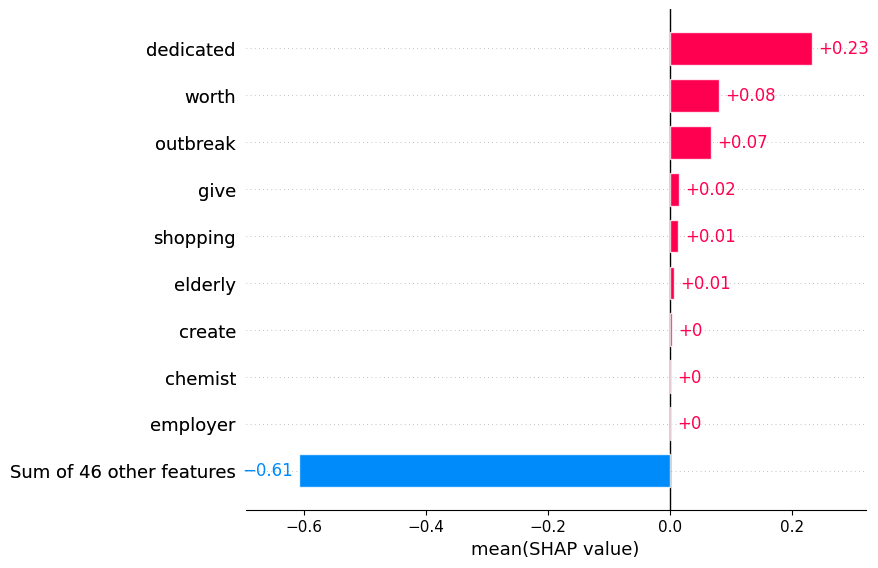

In [53]:
shap.plots.bar(shap_values[:,:,"LABEL_4"].mean(0))
shap.plots.bar(shap_values[:,:,"LABEL_4"].mean(0), order=shap.Explanation.argsort)
shap.plots.bar(shap_values[:,:,"LABEL_4"].mean(0), order=shap.Explanation.argsort.flip)

## Correlate sentiment to other features

## date

In [96]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import nltk
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [219]:
# Load your data into a Pandas DataFrame
dataint = pd.read_csv("Corona_NLP_train.csv", encoding='latin-1')
df = dataint[['Location', 'TweetAt', 'OriginalTweet', 'Sentiment']]
df['TweetAt'] = pd.to_datetime(df['TweetAt'], errors='coerce')
df

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Location    TweetAt  \
0                            London 2020-03-16   
1                                UK 2020-03-16   
2                         Vagabonds 2020-03-16   
3                               NaN 2020-03-16   
4                               NaN 2020-03-16   
...                             ...        ...   
41152  Wellington City, New Zealand 2020-04-14   
41153                           NaN 2020-04-14   
41154                           NaN 2020-04-14   
41155                           NaN 2020-04-14   
41156  i love you so much || he/him 2020-04-14   

                                           OriginalTweet           Sentiment  
0      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1      advice Talk to your neighbours family to excha...            Positive  
2      Coronavirus Australia: Woolworths to give elde...            Positive  
3      My food stock is not the only one which is emp...            Positive  
4      Me, ready to go at supermarket during the #COV...  Extremely Negative  
...                                                  ...                 ...  
41152  Airline pilots offering to stock supermarket s...             Neutral  
41153  Response to complaint not provided citing COVI...  Extremely Negative  
41154  You know itÂs getting tough when @KameronWild...            Positive  
41155  Is it wrong that the smell of hand sanitizer i...             Neutral  
41156  @TartiiCat Well new/used Rift S are going for ...            Negative  

[41157 rows x 4 columns]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.



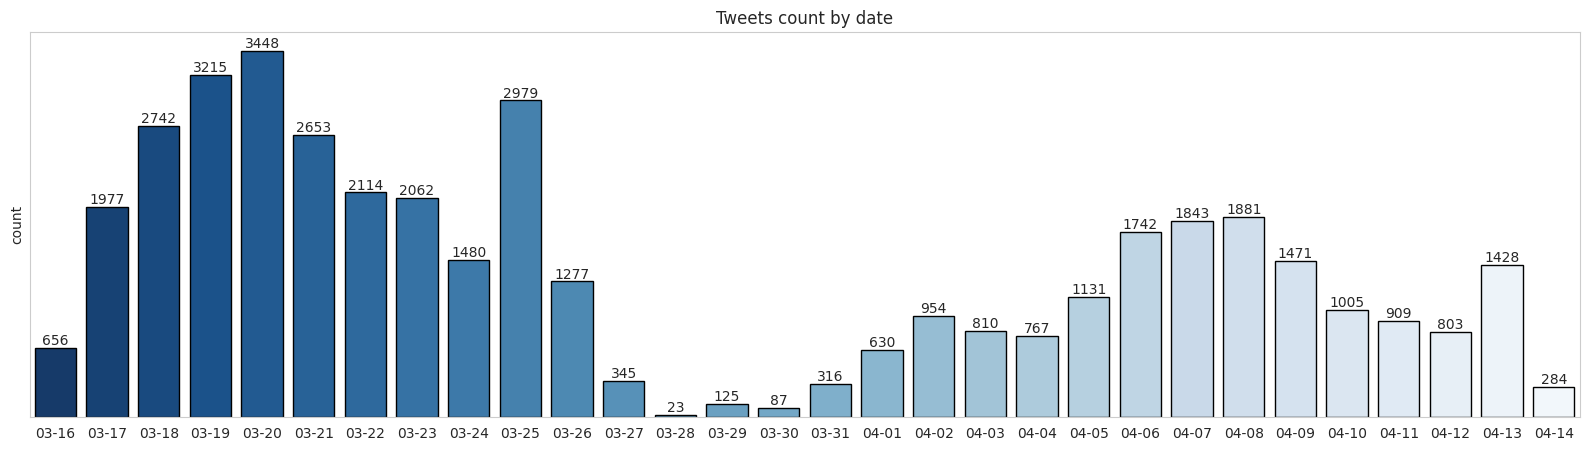

In [222]:
# convert "TweetAt" column to datetime format
df['TweetAt'] = pd.to_datetime(df['TweetAt'], format='%m/%d/%Y')

# filter dataframe for dates outside the given range
out_of_range = df[(df['TweetAt'] < '2020-03-16') | (df['TweetAt'] > '2020-04-14')]

# reverse day and month for out-of-range dates
out_of_range['TweetAt'] = out_of_range['TweetAt'].dt.strftime('%d-%m-%Y')

# combine filtered and updated dataframes
updated_df = pd.concat([df[(df['TweetAt'] >= '2020-03-16') & (df['TweetAt'] <= '2020-04-14')], out_of_range])
updated_df['TweetAt'] = pd.to_datetime(updated_df['TweetAt'], errors='coerce')

# count tweets by date and plot
tweets_per_day = updated_df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

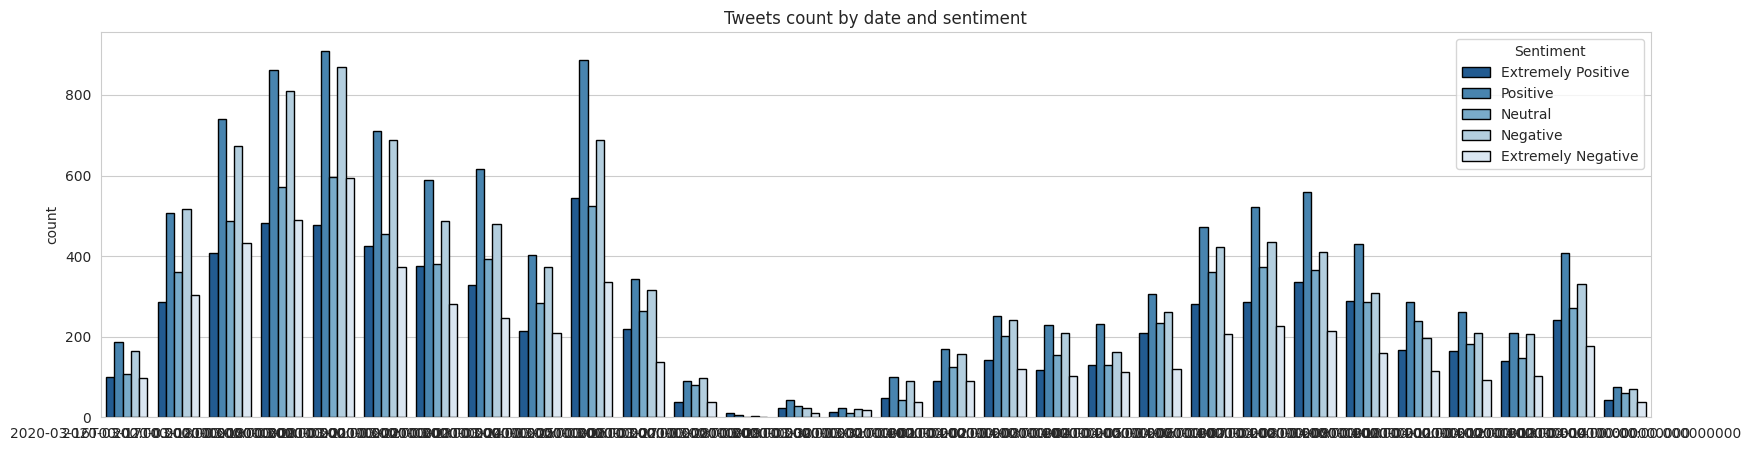

In [225]:
# Calculate tweet counts by date and sentiment
tweets_per_day_sentiment = updated_df.groupby(['TweetAt', 'Sentiment'])['Sentiment'].count().reset_index(name='counts')
# plot the stacked bar chart for all sentiment levels
sns.set_style("whitegrid")
plt.figure(figsize=(20,5))
sns.barplot(x='TweetAt', y='counts', hue='Sentiment', data=tweets_per_day_sentiment,
            hue_order=['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative'],
            palette='Blues_r', edgecolor='black')
plt.title('Tweets count by date and sentiment')
plt.ylabel('count')
plt.xlabel('')
plt.show()

<Figure size 2000x500 with 0 Axes>

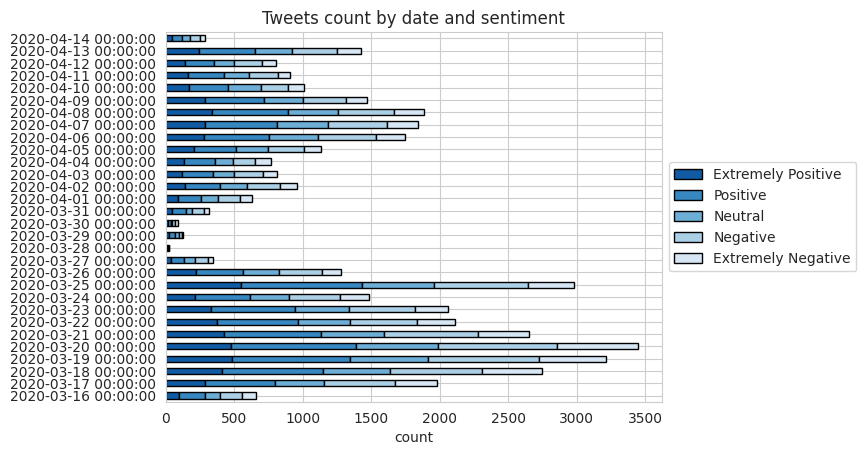

In [226]:
# Calculate tweet counts by date and sentiment
tweets_per_day_sentiment = updated_df.groupby(['TweetAt', 'Sentiment'])['Sentiment'].count().reset_index(name='counts')

# Set the order of sentiment levels
sentiment_order = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']

# Create a pivot table to get the counts by date and sentiment
tweets_per_day_sentiment_pivot = tweets_per_day_sentiment.pivot(index='TweetAt', columns='Sentiment', values='counts').fillna(0)
tweets_per_day_sentiment_pivot = tweets_per_day_sentiment_pivot[sentiment_order]

# Create a horizontal bar chart
sns.set_style("whitegrid")
plt.figure(figsize=(20,5))
tweets_per_day_sentiment_pivot.plot(kind='barh', stacked=True, edgecolor='black',
                                    color=sns.color_palette('Blues_r', len(sentiment_order)))
plt.title('Tweets count by date and sentiment')
plt.ylabel('')
plt.xlabel('count')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<Figure size 2000x500 with 0 Axes>

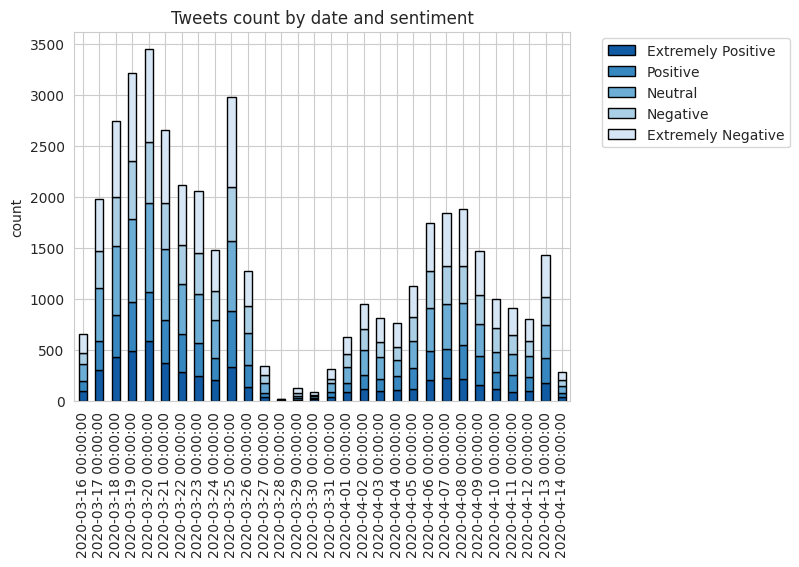

In [239]:
# Set the order of the sentiment levels
sentiment_order = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']

# Calculate tweet counts by date and sentiment
tweets_per_day_sentiment = updated_df.groupby(['TweetAt', 'Sentiment'])['Sentiment'].count().reset_index(name='counts')

# Pivot the DataFrame to create a table with dates as rows and sentiment levels as columns
tweets_pivot = tweets_per_day_sentiment.pivot(index='TweetAt', columns='Sentiment', values='counts')

# Plot the grouped bar chart
plt.figure(figsize=(20,5))
tweets_pivot.plot(kind='bar', stacked=True, color=sns.color_palette('Blues_r', n_colors=len(sentiment_order)),
                  edgecolor='black')
plt.title('Tweets count by date and sentiment')
plt.ylabel('count')
plt.xlabel('')
plt.xticks(rotation=90)
plt.legend(sentiment_order, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## City



The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.



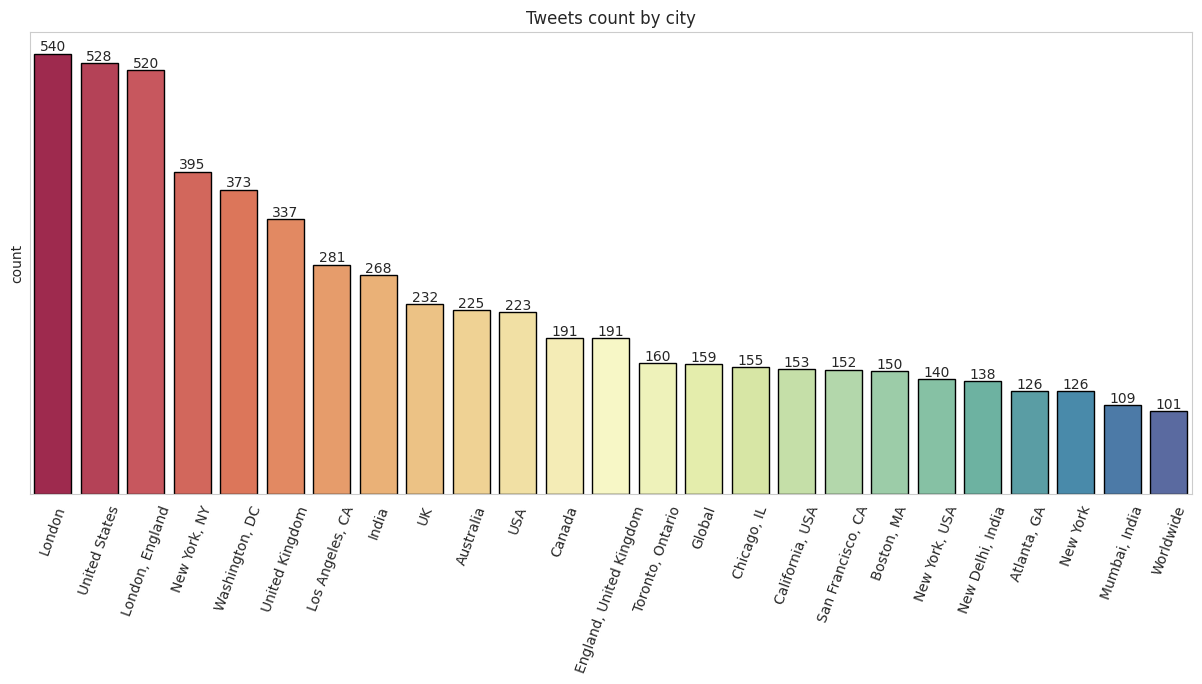

In [164]:
tweets_per_country = df['Location'].value_counts().loc[df['Location'].value_counts() > 100].reset_index(name='counts')
plt.figure(figsize=(15,6))
ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')
plt.title('Tweets count by city')
plt.xticks(rotation=70)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

<Figure size 2000x500 with 0 Axes>

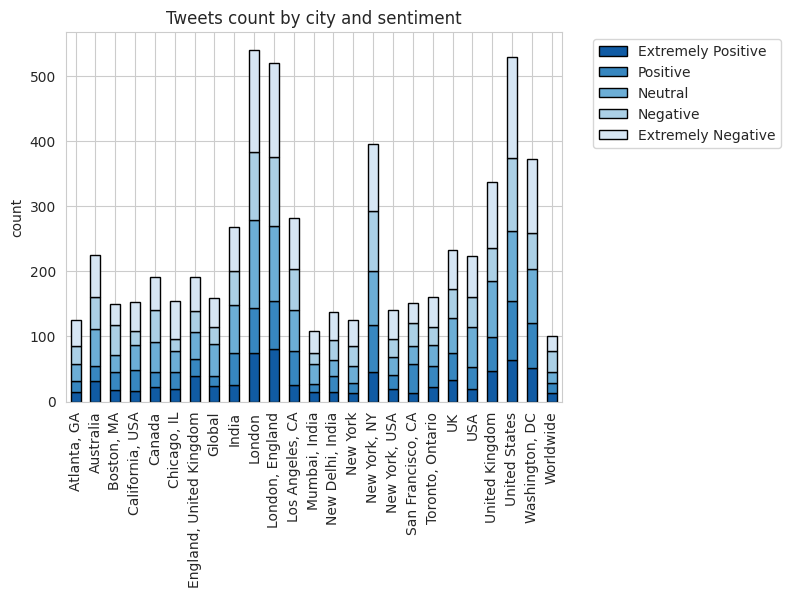

In [180]:
# Set the order of the sentiment levels
sentiment_order = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']

# Calculate tweet counts by date and sentiment
tweets_per_country_sentiment = df.groupby(['Location', 'Sentiment'])['Sentiment'].count().reset_index(name='counts')
tweets_per_country_sentiment = tweets_per_country_sentiment[tweets_per_country_sentiment['Location'].isin(tweets_per_country[tweets_per_country['counts'] >= 100]['index'])]
# Pivot the DataFrame to create a table with dates as rows and sentiment levels as columns
tweets_pivot = tweets_per_country_sentiment.pivot(index='Location', columns='Sentiment', values='counts')

# Plot the grouped bar chart
plt.figure(figsize=(20,5))
tweets_pivot.plot(kind='bar', stacked=True, color=sns.color_palette('Blues_r', n_colors=len(sentiment_order)),
                  edgecolor='black')
plt.title('Tweets count by city and sentiment')
plt.ylabel('count')
plt.xlabel('')
plt.xticks(rotation=90)
plt.legend(sentiment_order, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 2000x500 with 0 Axes>

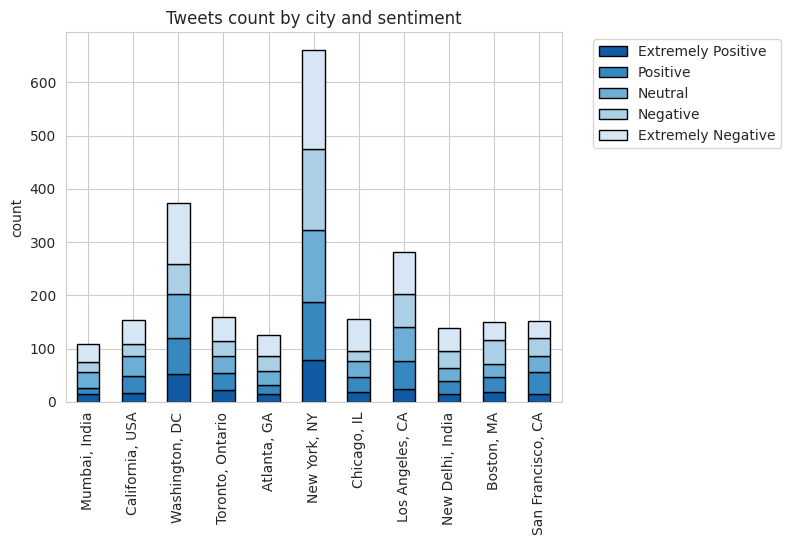

In [204]:
# Set the order of the sentiment levels
sentiment_order = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']
# Calculate tweet counts by location and sentiment
tweets_per_country_sentiment = df.groupby(['Location', 'Sentiment'])['Sentiment'].count().reset_index(name='counts')
# Filter locations with fewer than 50 tweets
tweets_per_country_sentiment = tweets_per_country_sentiment[tweets_per_country_sentiment['Location'].isin(tweets_per_country[tweets_per_country['counts'] >= 50]['index'])]

# Define a list of locations to exclude
exclude_locations = ['London', 'London, England', 'United States', 'United Kingdom', 'India', 'Australia', 'UK', 'Global', 'USA', 'England, United Kingdom', 'Canada', 'Worldwide']
# Filter out the rows that contain the excluded locations
tweets_per_country_sentiment = tweets_per_country_sentiment[~tweets_per_country_sentiment['Location'].isin(exclude_locations)]
# Define a dictionary of old and new values
location_recode = {
    'New York': 'New York, NY',
    'New York, USA': 'New York, NY',
}
# Replace the old values with the new values
df['Location'] = df['Location'].replace(location_recode)

# Pivot the DataFrame to create a table with locations as rows and sentiment levels as columns
tweets_pivot = tweets_per_country_sentiment.pivot(index='Location', columns='Sentiment', values='counts')
# Calculate the sum of the counts for the "Extremely Negative" and "Negative" sentiment levels
tweets_pivot['negative_sum'] = (tweets_pivot['Negative'] + tweets_pivot['Extremely Negative'])/tweets_pivot.sum(axis=1)
# Sort the DataFrame by the sum of the counts for the "Extremely Negative" and "Negative" sentiment levels
tweets_pivot = tweets_pivot.sort_values('negative_sum', ascending=False)

# Plot the grouped bar chart
plt.figure(figsize=(20,5))
tweets_pivot.drop('negative_sum', axis=1).plot(kind='bar', stacked=True, 
                                               color=sns.color_palette('Blues_r', n_colors=len(sentiment_order)),
                                               edgecolor='black')
plt.title('Tweets count by city and sentiment')
plt.ylabel('count')
plt.xlabel('')
plt.xticks(rotation=90)
plt.legend(sentiment_order, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 2000x500 with 0 Axes>

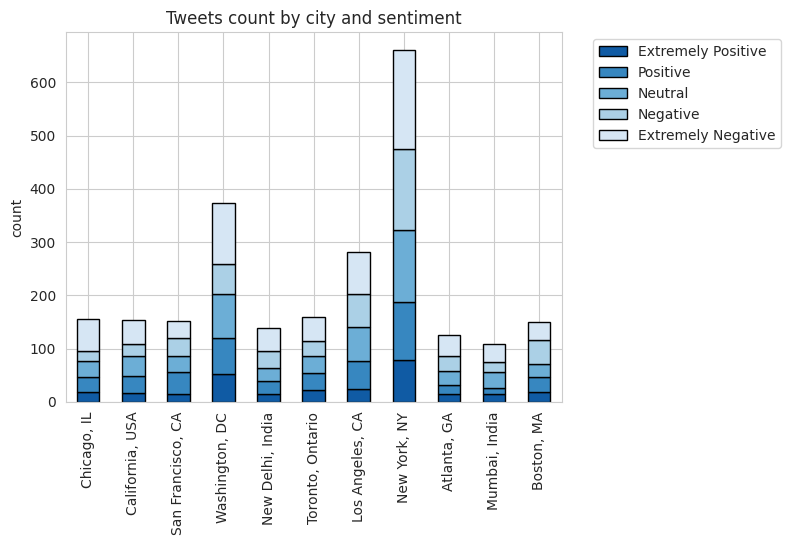

In [205]:
sentiment_order = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative']
tweets_per_country_sentiment = df.groupby(['Location', 'Sentiment'])['Sentiment'].count().reset_index(name='counts')
tweets_per_country_sentiment = tweets_per_country_sentiment[tweets_per_country_sentiment['Location'].isin(tweets_per_country[tweets_per_country['counts'] >= 50]['index'])]

exclude_locations = ['London', 'London, England', 'United States', 'United Kingdom', 'India', 'Australia', 'UK', 'Global', 'USA', 'England, United Kingdom', 'Canada', 'Worldwide']
tweets_per_country_sentiment = tweets_per_country_sentiment[~tweets_per_country_sentiment['Location'].isin(exclude_locations)]
location_recode = {
    'New York': 'New York, NY',
    'New York, USA': 'New York, NY',
}
df['Location'] = df['Location'].replace(location_recode)

tweets_pivot = tweets_per_country_sentiment.pivot(index='Location', columns='Sentiment', values='counts')
tweets_pivot['positive_sum'] = (tweets_pivot['Positive'] + tweets_pivot['Extremely Positive'])/ tweets_pivot.sum(axis=1)
tweets_pivot = tweets_pivot.sort_values('positive_sum', ascending=False)

plt.figure(figsize=(20,5))
tweets_pivot.drop('positive_sum', axis=1).plot(kind='bar', stacked=True, 
                                               color=sns.color_palette('Blues_r', n_colors=len(sentiment_order)),
                                               edgecolor='black')
plt.title('Tweets count by city and sentiment')
plt.ylabel('count')
plt.xlabel('')
plt.xticks(rotation=90)
plt.legend(sentiment_order, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()